# Задача 3. Применение рекуррентной нейронной сети для аннотации текста
1. Загрузить текстовый корпус, например, набор предложений с метками части речи (POS-tagging).
2. Построить и обучить рекуррентную нейронную сеть (RNN или LSTM) для предсказания аннотаций текста.
3. Оценить модель на тестовом наборе и сравнить предсказанные метки с реальными.
4. Вывести 5 примеров предложений с предсказанными и реальными аннотациями.


## Загрузка корпуса с метками части речи

Загрузим корпус в виде итератора пар (слово - часть речи). Игнорируем морфологические признаки из датасета.
Каждое предложение завершаем точкой, если нету никакого знака препинания. Это пригодится для моделей, использующих контекст токенов.

In [1]:
f = open("samples3", mode="r", encoding="utf-8")

def process_line(line: str) -> list[str]:
    tokens = line.split('\t')
    return tokens
    
def iter_process(it):
    punkt = ['.', 'PUNCT']
    
    last_pos = 'X'
    try:
        while True:
            line = next(it)
            tokens = process_line(line)
            if len(tokens) < 2:
                continue    
            elif tokens[1][0] == '<':
                if tokens[1][1] == 'e' and last_pos != 'PUNCT':  #end
                    last_pos = 'PUNCT'
                    yield punkt
                continue
            
            word_str = tokens[1]
            characteristics_str = tokens[2]
            
            sep_index = characteristics_str.find('|')
            pos_str = characteristics_str[:sep_index]
            
            last_pos = pos_str
            yield [word_str, pos_str]
    except StopIteration:
        it.seek(0)
        return

In [2]:
corpus_it = iter_process(f)
corpus = list(corpus_it)

for i in range(10):
    print(corpus[i])

['рой', 'VERB']
['колодец', 'NOUN']
['.', 'PUNCT']
['рой', 'VERB']
['погреб', 'NOUN']
['.', 'PUNCT']
['рой', 'VERB']
['укрытие', 'NOUN']
['.', 'PUNCT']
['я', 'PRON']


## Попытка обучить нейросеть с прямой связью
Первый вопрос, который возник при виде условия - "Почему LSTM/RNN?"
В качестве эксперимента и ответа на вопрос рассмотрим результаты обучения нейросети только с Linear и Dropout слоями на самописных эмбеддингах слов.

### Расчёт эмбеддингов слов. 
Рассчитываем эмбеддинг на основе количества символов с конца слова (предполагаем, что последние символы - изменяемые части слова, поэтому могут определять часть речи) для расчёта.

### Предобработка результирующего столбца (часть речи)
Категориальный признак преобразуем в числовое значение в диапазоне $[1, n]$, где $n$ - количество классов (частей речи) в датасете.

In [11]:
from wannabe_embedder import make_embeddings_and_outputs

n = 12
embedding_dim = n

indexes_in_corpus, embeddings, outputs = make_embeddings_and_outputs(corpus, n)

for i in range(5):
    print(indexes_in_corpus[i], embeddings[i], outputs[i])

0 [  0   0   0   0   0   0   0   0   0 224 222 217] 1
1 [  0   0   0   0   0 218 222 219 222 212 213 230] 0
2 [ 0  0  0  0  0  0  0  0  0  0  0 46] 5
3 [  0   0   0   0   0   0   0   0   0 224 222 217] 1
4 [  0   0   0   0   0   0 223 222 211 224 213 209] 0


In [ ]:
from helpers import save_embeddings_data

save_embeddings_data(indexes_in_corpus, embeddings, outputs, 'embeddings/embeddings.pkl')

In [ ]:
from helpers import load_embeddings_data

indexes_in_corpus, embeddings, outputs = load_embeddings_data('embeddings/embeddings.pkl')

## Построение и обучение нейросети

In [12]:
import torch

device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

# !nvidia-smi

Using cuda device


Преобразуем массивы входных данных в тензоры PyTorch, создадим загрузчик данных. Размер батча задаём большим, так как используется GPU

In [ ]:
from torch.utils.data import TensorDataset, DataLoader
from torch import nn
import torch.nn.functional as F

tensor_embeddings = torch.Tensor(embeddings).to(device)
tensor_outputs = torch.Tensor(outputs).to(device)

In [14]:
pos_dataset = TensorDataset(tensor_embeddings, tensor_outputs)
batch_size = 2048
pos_dataloader = DataLoader(pos_dataset, batch_size=batch_size)

Зададим нейросеть с прямыми связями

In [15]:
from constants import POS_MAPPING


class SimplePOSTagger(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, num_tags):
        super(SimplePOSTagger, self).__init__()
        
        self.fc1 = nn.Linear(embedding_dim, hidden_dim).to(device)
        # self.fc2 = nn.Linear(hidden_dim, hidden_dim).to(device)
        self.dropout = nn.Dropout(0.1).to(device)
        self.fc3 = nn.Linear(hidden_dim, num_tags).to(device)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        # x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

hidden_dim = 128
num_tags = len(POS_MAPPING)
model = SimplePOSTagger(embedding_dim=embedding_dim, hidden_dim=hidden_dim, num_tags=num_tags).to(device)
print(model)

loss = nn.CrossEntropyLoss()
loss.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

SimplePOSTagger(
  (fc1): Linear(in_features=12, out_features=128, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (fc3): Linear(in_features=128, out_features=15, bias=True)
)


In [16]:
num_epochs = 25
model.train()

for epoch in range(num_epochs):
    running_loss = 0.0
    correct = 0
    total = 0
    
    for batch_idx, (inputs, labels) in enumerate(pos_dataloader):
        # Обнуляем градиенты
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        loss_value = loss(outputs, labels.long())
        
        # Backward pass и оптимизация
        loss_value.backward()
        optimizer.step()
        
        running_loss += loss_value.item()
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
    
    epoch_loss = running_loss / len(pos_dataloader)
    accuracy = correct / total
    
    print(f'epoch {epoch + 1},\tloss: {epoch_loss:.4f},\taccuracy: {accuracy:.4f}')

epoch 1,	loss: 3.6374,	accuracy: 0.4261
epoch 2,	loss: 1.1185,	accuracy: 0.5610
epoch 3,	loss: 1.0566,	accuracy: 0.5734
epoch 4,	loss: 1.0375,	accuracy: 0.5808
epoch 5,	loss: 1.0236,	accuracy: 0.5864
epoch 6,	loss: 1.0137,	accuracy: 0.5895
epoch 7,	loss: 1.0042,	accuracy: 0.5939
epoch 8,	loss: 0.9964,	accuracy: 0.5970
epoch 9,	loss: 0.9888,	accuracy: 0.6001
epoch 10,	loss: 0.9782,	accuracy: 0.6060
epoch 11,	loss: 0.9689,	accuracy: 0.6105
epoch 12,	loss: 0.9603,	accuracy: 0.6140
epoch 13,	loss: 0.9535,	accuracy: 0.6157
epoch 14,	loss: 0.9470,	accuracy: 0.6184
epoch 15,	loss: 0.9442,	accuracy: 0.6189
epoch 16,	loss: 0.9391,	accuracy: 0.6210
epoch 17,	loss: 0.9351,	accuracy: 0.6219
epoch 18,	loss: 0.9309,	accuracy: 0.6238
epoch 19,	loss: 0.9270,	accuracy: 0.6253
epoch 20,	loss: 0.9241,	accuracy: 0.6267
epoch 21,	loss: 0.9208,	accuracy: 0.6282
epoch 22,	loss: 0.9173,	accuracy: 0.6292
epoch 23,	loss: 0.9146,	accuracy: 0.6298
epoch 24,	loss: 0.9134,	accuracy: 0.6302
epoch 25,	loss: 0.9108,	a

In [17]:
from constants import MODEL_PATH
from helpers import save_model

save_model(model, optimizer, num_epochs, epoch_loss, MODEL_PATH)

## Примеры предсказаний

In [82]:
def evaluate_model(model, dataloader):
    model.eval()
    predictions = []
    labels = []
    
    with torch.no_grad():
        for inputs, targets in dataloader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            
            predictions.extend(predicted.cpu().numpy())
            labels.extend(targets.cpu().numpy())
            
    return predictions, labels

In [30]:
from constants import INVERSE_POS_MAPPING

test_f = open("test_samples", mode="r", encoding="utf-8")
test_corpus_it = iter_process(test_f)
test_corpus = list(test_corpus_it)

test_f.close()

test_idx_in_corpus, test_embeddings, test_outputs = make_embeddings_and_outputs(test_corpus, n)

test_embeddings = torch.Tensor(test_embeddings).to(device)
test_outputs = torch.Tensor(test_outputs).to(device)

test_dataset = TensorDataset(
    test_embeddings,
    test_outputs
)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

predictions, labels = evaluate_model(model, test_dataloader)

heads = ['Слово', 'Прогноз', 'Фактически']
print(*[f"{heads[0]:^20} | ", f"{heads[1]:^14} | ", f"{heads[2]:^14}"])
print("-" * (22 + 17 + 17))

for i, index_in_corpus in enumerate(test_idx_in_corpus):
    word = test_corpus[index_in_corpus][0]
    pred_tag = INVERSE_POS_MAPPING[predictions[i]]
    actual_tag = test_corpus[index_in_corpus][1]

    print(f"{word:20} | {pred_tag:^15} | {actual_tag:^15}")

       Слово         |     Прогноз     |    Фактически  
--------------------------------------------------------
ребята               |      NOUN       |      NOUN      
,                    |      PUNCT      |      PUNCT     
которые              |      NOUN       |       ADJ      
посмелей             |      NOUN       |       ADJ      
,                    |      PUNCT      |      PUNCT     
конечно              |      NOUN       |       ADV      
,                    |      PUNCT      |      PUNCT     
уехали               |      NOUN       |      VERB      
на                   |       ADP       |       ADP      
крышах               |      NOUN       |      NOUN      
и                    |       ADP       |      CONJ      
на                   |       ADP       |       ADP      
подножках            |      VERB       |      NOUN      
,                    |      PUNCT      |      PUNCT     
а                    |       ADP       |      CONJ      
я                    |       AD

In [22]:
from helpers import load_model

loaded_model, loaded_optimizer, loaded_epoch, loaded_loss = load_model(model, optimizer, MODEL_PATH)


## Словарь с индексами слов для эмбеддингов

In [54]:
class SecondPOSTagger(nn.Module):
    def __init__(self, vocab_size: int, embedding_dim: int, hidden_dim: int, 
                 pos_tag_count: int):
        super(SecondPOSTagger, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.fc1 = nn.Linear(embedding_dim, hidden_dim)
        self.dropout = nn.Dropout(p=0.2)
        self.fc2 = nn.Linear(hidden_dim, pos_tag_count)

    def forward(self, x):
        embeds = self.embedding(x)
        out = F.relu(self.fc1(embeds))
        out = self.dropout(out)
        return self.fc2(out)

In [80]:
from typing import Tuple, Dict, List


def prepare_data(corpus: List[Tuple[str, str]]) -> Tuple[Dict[str, int], Dict[str, int]]:
    word_to_ix = {}
    pos_to_ix = {}
    
    # Создаем словари для слов и частей речи
    for word, pos in corpus:
        if word not in word_to_ix:
            word_to_ix[word] = len(word_to_ix)
        if pos not in pos_to_ix:
            pos_to_ix[pos] = len(pos_to_ix)
    
    return word_to_ix, pos_to_ix

def train_model(model: SecondPOSTagger, device: torch.device, 
                optimizer: torch.optim.Optimizer, loss_fn: nn.CrossEntropyLoss,
                batch: Tuple[torch.Tensor, torch.Tensor]) -> float:
    model.train()
    optimizer.zero_grad()
    
    inputs, labels = batch
    inputs, labels = inputs.to(device), labels.to(device)
    
    outputs = model(inputs)
    loss = loss_fn(outputs, labels)
    
    loss.backward()
    optimizer.step()
    
    return loss.item()


def evaluate_second_model(model: SecondPOSTagger, device: torch.device, loss_fn: nn.CrossEntropyLoss, batch: Tuple[torch.Tensor, torch.Tensor]) -> Tuple[float, float]:
    model.eval()
    inputs, labels = batch
    inputs, labels = inputs.to(device), labels.to(device)
    
    outputs = model(inputs)
    loss = loss_fn(outputs, labels)
    _, predicted = torch.max(outputs, dim=1)
    accuracy = (predicted == labels).sum().item() / len(labels)
    
    return loss.item(), accuracy


def apply_model_on_new_data(model: SecondPOSTagger, device: torch.device, word_to_ix: Dict[str, int], pos_to_ix: Dict[str, int]) -> None:
    test_f = open("test_samples", mode="r", encoding="utf-8")
    test_corpus_it = iter_process(test_f)
    test_corpus = list(test_corpus_it)
    test_f.close()
    
    word_indices = [word_to_ix.get(word, 0) for word, _ in test_corpus]
    pos_indices = [pos_to_ix[pos] for _, pos in test_corpus]
    
    inputs_tensor = torch.tensor(word_indices, dtype=torch.long).to(device)
    labels_tensor = torch.tensor(pos_indices, dtype=torch.long).to(device)
    
    test_dataset = TensorDataset(inputs_tensor, labels_tensor)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size)
    
    predictions, labels = evaluate_model(model, test_dataloader)
    
    heads = ['Слово', 'Прогноз', 'Фактически']
    print(*[f"{heads[0]:^20} | ", f"{heads[1]:^14} | ", f"{heads[2]:^14}"])
    print("-" * (22 + 17 + 17))
    
    # Получаем обратные отображения для частей речи
    inverse_pos_mapping = {v: k for k, v in pos_to_ix.items()}
    
    for i, (word, pos) in enumerate(test_corpus):
        pred_tag = inverse_pos_mapping[predictions[i]]
        actual_tag = pos
        print(f"{word:20} | {pred_tag:^15} | {actual_tag:^15}")

In [85]:
embedding_dim = 100
hidden_dim = 128
batch_size = 1024
epochs = 10

word_to_ix, pos_to_ix = prepare_data(corpus)
vocab_size = len(word_to_ix)
pos_tag_count = len(pos_to_ix)

# Создание модели и оптимизатора
model = SecondPOSTagger(vocab_size, embedding_dim, hidden_dim, pos_tag_count)
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

print(model)

SecondPOSTagger(
  (embedding): Embedding(111008, 100)
  (fc1): Linear(in_features=100, out_features=128, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=128, out_features=12, bias=True)
)


In [87]:
word_indices = [word_to_ix[word] for word, _ in corpus]
pos_indices = [pos_to_ix[pos] for _, pos in corpus]

train_inputs = torch.tensor(word_indices[:-100], dtype=torch.long)
train_labels = torch.tensor(pos_indices[:-100], dtype=torch.long)
test_inputs = torch.tensor(word_indices[-100:], dtype=torch.long)
test_labels = torch.tensor(pos_indices[-100:], dtype=torch.long)

for epoch in range(epochs):
    indices = torch.randperm(len(train_inputs))
    train_inputs = train_inputs[indices]
    train_labels = train_labels[indices]
    
    total_loss = 0
    batches = len(train_inputs) // batch_size
    
    for i in range(batches):
        start_idx = i * batch_size
        inputs_batch = train_inputs[start_idx:start_idx + batch_size]
        labels_batch = train_labels[start_idx:start_idx + batch_size]
        
        batch = (inputs_batch, labels_batch)
        loss = train_model(model, device, optimizer, loss_fn, batch)
        total_loss += loss
        
        if (i + 1) % 500 == 0:
            test_batch = (test_inputs[:batch_size], test_labels[:batch_size])
            test_loss, accuracy = evaluate_second_model(model, device, loss_fn, test_batch)
            print(f'epoch {epoch+1}, batch {i+1}/{batches}, train loss: {total_loss/(i+1):.4f}, test loss: {test_loss:.4f}, accuracy: {accuracy:.4f}')

epoch 1, batch 500/1020, train loss: 0.6738, test loss: 0.5755, accuracy: 0.7200
epoch 1, batch 1000/1020, train loss: 0.5755, test loss: 0.4469, accuracy: 0.8300
epoch 2, batch 500/1020, train loss: 0.3655, test loss: 0.3688, accuracy: 0.8600
epoch 2, batch 1000/1020, train loss: 0.3396, test loss: 0.3480, accuracy: 0.8900
epoch 3, batch 500/1020, train loss: 0.2526, test loss: 0.3195, accuracy: 0.9100
epoch 3, batch 1000/1020, train loss: 0.2407, test loss: 0.3041, accuracy: 0.9100
epoch 4, batch 500/1020, train loss: 0.1888, test loss: 0.2997, accuracy: 0.9100
epoch 4, batch 1000/1020, train loss: 0.1824, test loss: 0.2753, accuracy: 0.9200
epoch 5, batch 500/1020, train loss: 0.1457, test loss: 0.2780, accuracy: 0.9100
epoch 5, batch 1000/1020, train loss: 0.1431, test loss: 0.2929, accuracy: 0.9100
epoch 6, batch 500/1020, train loss: 0.1169, test loss: 0.2697, accuracy: 0.9200
epoch 6, batch 1000/1020, train loss: 0.1154, test loss: 0.2830, accuracy: 0.9200
epoch 7, batch 500/102

In [91]:
from helpers import save_model

save_model(model, optimizer, num_epochs, epoch_loss, "pos_tagger_model2")

In [90]:
apply_model_on_new_data(model, device, word_to_ix, pos_to_ix)

       Слово         |     Прогноз     |    Фактически  
--------------------------------------------------------
очень                |       ADV       |        X       
сложная              |       ADJ       |        X       
лабораторная         |      VERB       |        X       
попалась             |      VERB       |        X       
,                    |      PUNCT      |        X       
не                   |      PART       |        X       
получается           |      VERB       |        X       
её                   |      VERB       |        X       
доделать             |      VERB       |        X       
в                    |       ADP       |        X       
срок                 |      NOUN       |        X       
.                    |      PUNCT      |      PUNCT     
ребята               |      NOUN       |      NOUN      
,                    |      PUNCT      |      PUNCT     
которые              |       ADJ       |       ADJ      
посмелей             |      VER

Получилась неплохая точность (95%), но модель не работает на данных, которых не было в маппинге тренировочного датасета. Это проблема эмбеддингов, а не самой модели.
Также модель имеет очень большой размер (130 МБ) за счет слоя эмбеддингов. 
Попробуем устранить эти недостатки.

## Нормальные эмбеддинги (navec)

https://storage.yandexcloud.net/natasha-navec/packs/navec_hudlit_v1_12B_500K_300d_100q.tar

In [89]:
from navec import Navec

navec = Navec.load('embeddings/navec_hudlit_v1_12B_500K_300d_100q.tar')

In [134]:
# Построение предложений
sentences, tags = [], []
current_sentence, current_tags = [], []

for word, tag in corpus:
    current_sentence.append(word)
    current_tags.append(tag)
    if word == '.':
        sentences.append(current_sentence)
        tags.append(current_tags)
        current_sentence, current_tags = [], []

# Словарь тегов
tag2idx = {tag: idx for idx, tag in enumerate(set(tag for s in tags for tag in s))}
idx2tag = {idx: tag for tag, idx in tag2idx.items()}

In [135]:
from torch.utils.data import Dataset


class PosDataset(Dataset):
    def __init__(self, sentences, tags):
        self.sentences = sentences
        self.tags = tags

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        sentence = self.sentences[idx]
        tag_seq = self.tags[idx]
        vectors = [torch.tensor(navec.get(w, navec['<unk>'])) for w in sentence]
        tag_ids = torch.tensor([tag2idx[t] for t in tag_seq])
        return torch.stack(vectors), tag_ids, sentence  # добавляем слова для вывода

def collate_fn(batch):
    sentences, tags, words = zip(*batch)
    sentences_padded = pad_sequence(sentences, batch_first=True)
    tags_padded = pad_sequence(tags, batch_first=True, padding_value=-1)
    lengths = torch.tensor([len(s) for s in sentences])
    return sentences_padded, tags_padded, lengths, words

In [140]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader


batch_size = 2048
num_epochs = 10

train_sents, test_sents, train_tags, test_tags = train_test_split(sentences, tags, test_size=0.2, random_state=42)

train_loader = DataLoader(PosDataset(train_sents, train_tags), batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(PosDataset(test_sents, test_tags), batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

# min = 107
# max = min + 1
# print(test_sents[min:max], test_tags[min:max])


In [141]:
import torch
import torch.nn as nn
import torch.optim as optim


class POSTagger(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, tagset_size):
        super().__init__()
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, tagset_size)

    def forward(self, x, lengths):
        packed = nn.utils.rnn.pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)
        lstm_out, _ = self.lstm(packed)
        unpacked, _ = nn.utils.rnn.pad_packed_sequence(lstm_out, batch_first=True)
        return self.fc(unpacked)

In [142]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = POSTagger(embedding_dim=navec.pq.dim, hidden_dim=128, tagset_size=len(tag2idx)).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=-1).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

print("model on", device)

model on cuda


In [143]:
from torch.nn.utils.rnn import pad_sequence

total_loss = 0

model.train()
for epoch in range(num_epochs):
    total_loss = 0
    
    for batch_idx, (batch_x, batch_y, lengths, _) in enumerate(train_loader):
        batch_x, batch_y, lengths = batch_x.to(device), batch_y.to(device), lengths

        optimizer.zero_grad()
        outputs = model(batch_x, lengths)
        loss = criterion(outputs.view(-1, outputs.size(-1)), batch_y.view(-1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        
        if ((batch_idx + 1) % 201) == 0:
            print(f'epoch {epoch + 1}, batch {batch_idx}/{len(train_loader)}')
        
    print(f'epoch {epoch + 1},\tloss: {total_loss:.4f}')

epoch 1,	loss: 70.7527
epoch 2,	loss: 36.7629
epoch 3,	loss: 23.8556
epoch 4,	loss: 17.9606
epoch 5,	loss: 14.1566
epoch 6,	loss: 11.5412
epoch 7,	loss: 9.8033
epoch 8,	loss: 8.5908
epoch 9,	loss: 7.6888
epoch 10,	loss: 7.0127


In [144]:
from helpers import save_model

save_model(model, optimizer, num_epochs, total_loss, "pos_tagger_model3")

In [161]:
model.eval()
examples = []

samples_batches = 1
with torch.no_grad():
    for k, (batch_x, batch_y, lengths, words_batch) in enumerate(test_loader):
        if k >= samples_batches:
            break
        
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        outputs = model(batch_x, lengths)
        predictions = outputs.argmax(-1)

        mask = batch_y != -1
        for i in range(len(words_batch)):
            real_tags = [idx2tag[idx.item()] for idx in batch_y[i] if idx.item() != -1]
            pred_tags = [idx2tag[idx.item()] for idx in predictions[i][:len(real_tags)]]
            examples.append((words_batch[i], real_tags, pred_tags))

In [165]:
import pandas as pd

df = pd.DataFrame(
    [{
        'Предложение': ' '.join(words),
        'Фактически': ' '.join(real),
        'Предсказано': ' '.join(pred)
    } for words, real, pred in examples[5:10]]
)

print(df.to_string(index=False))

                                      Предложение                                                Фактически                                               Предсказано
света сидела рядом , красивая , обворожительная .                   NOUN VERB ADV PUNCT ADJ PUNCT ADJ PUNCT                   NOUN VERB ADV PUNCT ADJ PUNCT ADJ PUNCT
         сверкали молнии , то слева , то справа .             VERB NOUN PUNCT CONJ ADV PUNCT CONJ ADV PUNCT             VERB NOUN PUNCT CONJ ADV PUNCT CONJ ADV PUNCT
        и никто никогда мне печатно не возражал .                    CONJ PRON ADV PRON ADV PART VERB PUNCT                   CONJ PRON ADV PRON VERB PART VERB PUNCT
          я улетел из японии и стал жить дальше .               PRON VERB ADP NOUN CONJ VERB VERB ADV PUNCT               PRON VERB ADP NOUN CONJ VERB VERB ADV PUNCT
            " , " я на тебе никогда не женюсь " . PUNCT PUNCT PUNCT PRON ADP PRON ADV PART VERB PUNCT PUNCT PUNCT PUNCT PUNCT PRON ADP PRON ADV PART VERB PUNCT PUNCT


## Таким образом, LSTM показала внешне неплохие результаты в частеречной разметке

Посчитаем несколько метрик, потому что только accuracy - недостаточно репрезентативно

**Accuracy (Точность классификации в целом)**

$$
Accuracy = \frac{TP + TN}{TP + TN + FP + FN} = \frac{\text{правильных предсказаний}}{\text{всего тегов}}
$$

**Accuracy для конкретных тегов**

$$
Accuracy_i = \frac{TP_i}{TP_i + FN_i}
$$

**Precision (Точность для тега)**

Из всех предсказаний данного тега — сколько верных

$$
Precision_i = \frac{TP_i}{TP_i + FP_i}
$$

**Recall (Полнота для тега)**

Из всех реальных вхождений данного тега — сколько найдено

$$
Recall_i = \frac{TP_i}{TP_i + FN_i}
$$

**F1-score (Гармоническое среднее Precision и Recall)**

$$
F1_i = 2 \times \frac{Precision_i \times Recall_i}{Precision_i + Recall_i}
$$

**Sequence Accuracy (Точность по всей последовательности)**

$$
SeqAccuracy = \frac{\text{полностью правильно размеченных предложений}}{\text{общее число предложений}}
$$

In [157]:
all_preds = []
all_true = []

model.eval()
with torch.no_grad():
    for batch_x, batch_y, lengths, _ in test_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        outputs = model(batch_x, lengths)
        preds = outputs.argmax(dim=-1)

        mask = batch_y != -1
        all_preds.extend(preds[mask].tolist())
        all_true.extend(batch_y[mask].tolist())

In [158]:
import numpy as np
# --- Accuracy
acc = np.mean(np.array(all_preds) == np.array(all_true))
print(f'Accuracy: {acc:.4f}')

Accuracy: 0.9513


In [168]:
from sklearn.metrics import classification_report
# --- Precision / Recall / F1 по каждому тегу
print(classification_report(all_true, all_preds, target_names=[idx2tag[i] for i in range(len(tag2idx))], zero_division=np.nan))

              precision    recall  f1-score   support

         ADP       1.00      0.98      0.99     20049
         NUM       0.95      0.84      0.89      2437
         ADJ       0.94      0.89      0.91     22367
        NOUN       0.95      0.96      0.96     50635
        CONJ       0.95      0.92      0.93      9557
        PART       0.98      0.95      0.96      5823
        LATN       0.93      0.65      0.77       515
           X        nan      0.00      0.00       125
        VERB       0.97      0.97      0.97     29812
        PRON       0.98      0.98      0.98     13976
         ADV       0.94      0.85      0.89     12345
       PUNCT       0.91      0.99      0.95     41350

    accuracy                           0.95    208991
   macro avg       0.95      0.83      0.85    208991
weighted avg       0.95      0.95      0.95    208991


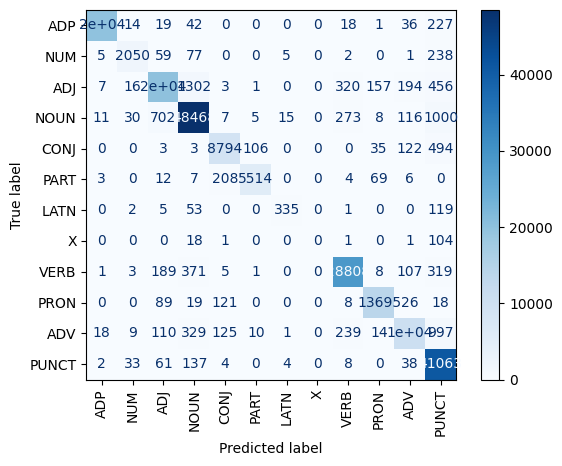


Accuracy по каждому тегу:
X          0.000
LATN       0.650
NUM        0.841
ADV        0.850
ADJ        0.890
CONJ       0.920
PART       0.947
NOUN       0.957
VERB       0.966
PRON       0.980
ADP        0.982
PUNCT      0.993


In [170]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt

# --- Матрица ошибок
cm = confusion_matrix(all_true, all_preds)
disp = ConfusionMatrixDisplay(cm, display_labels=[idx2tag[i] for i in range(len(tag2idx))])
disp.plot(xticks_rotation='vertical', cmap='Blues')
plt.show()

# --- Accuracy по каждому тегу отдельно
acc_per_class = {}
for idx in range(len(tag2idx)):
    true_idx = np.array(all_true) == idx
    pred_idx = np.array(all_preds) == idx
    correct = (true_idx & pred_idx).sum()
    total = true_idx.sum()
    acc_per_class[idx2tag[idx]] = correct / total if total > 0 else 0.0

print('\nAccuracy по каждому тегу:')
for tag, a in sorted(acc_per_class.items(), key=lambda x: x[1]):
    print(f'{tag:<10} {a:.3f}')

In [171]:
# --- Sequence Accuracy (всё предложение правильно)
seq_correct = 0
seq_total = 0

model.eval()
with torch.no_grad():
    for batch_x, batch_y, lengths, _ in test_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        outputs = model(batch_x, lengths)
        preds = outputs.argmax(dim=-1)

        for i, length in enumerate(lengths):
            true_seq = batch_y[i, :length].tolist()
            pred_seq = preds[i, :length].tolist()
            if true_seq == pred_seq:
                seq_correct += 1
            seq_total += 1

print(f'\nSequence Accuracy: {seq_correct / seq_total:.4f}')


Sequence Accuracy: 0.6426
